In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from scipy.sparse.linalg import gmres, LinearOperator
from util.unet import *

## Convolutional networks
Here, we define the map from boundary conditions + boundary parameterisations to the density by sequentially convolving with and applying non-linear activation functions.

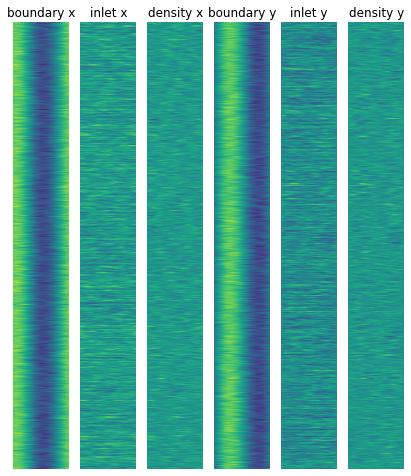

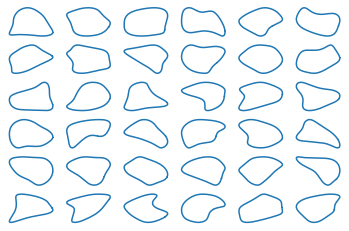

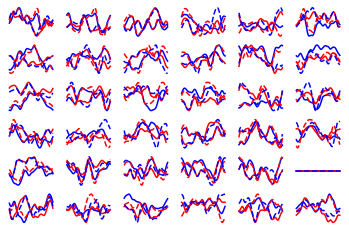

In [74]:
#data = torch.load("/home/emastr/phd/data/discretised_data_gradflow_big_TEST.torch")
data = torch.load("/home/emastr/phd/data/discretised_data_gradflow_big.torch")
#data = torch.load("/home/emastr/phd/data/discretised_data.torch")
#data = torch.load("data/discretised_data_gradflow_big.torch")
#data = torch.load("data/discretised_data_gradflow_big_circles.torch")

#X = data["X"][:,np.array([0,1,6,7]),:]
X = data["X"]
Y = data["Y"]

titles=["boundary x", "boundary y", "inlet x", "inlet y"]
plt.figure(figsize=(7,9))
for i in range(2):
    for j in range(2):
        plt.subplot(1,6,i+3*j+1)
        plt.imshow(X[:,2*i+j,:].squeeze().numpy())
        plt.title(titles[2*i+j])
        remove_axes(plt.gca())
        
ytitles = ["density x", "density y"]
for i in range(2):
    plt.subplot(1,6,3+3*i)
    plt.imshow(Y[:,i,:].squeeze().numpy())
    plt.title(ytitles[i])
    remove_axes(plt.gca())
    
plt.figure()
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.plot(X[i,0,:],X[i,1,:])
    remove_axes(plt.gca())
    
plt.figure()
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.plot(X[i,2,:],'b-')
    plt.plot(X[i,3,:],'r-')
    plt.plot(Y[i,0,:],'r--')
    plt.plot(Y[i,1,:],'b--')
    remove_axes(plt.gca())

In [83]:
from util.unet import *

settings = {"in_channels":X.shape[1], 
            "min_out_channels":Y.shape[1],
            "out_channels":2,
            "depth":5, 
            "batch_norm":2, 
            "width":2,
            "kernel_size":3,
            "padding":1,
            "activation":nn.Sigmoid
           }
#activations = {"sigmoid": nn.Sigmoid, "relu": nn.ReLU}
#settings["activation"] = activations[settings["activation"]]

unet = Unet(**settings)


loss = nn.MSELoss()
#loss = nn.SmoothL1Loss(beta=0.1)

#optim = torch.optim.SGD(unet.parameters(), lr=1e-3)
optim = torch.optim.Adam(unet.parameters(), weight_decay=0.001)#0.00001 # Use default parameters

n = int(0.7*X.shape[0]) # Train on 70%
Xtrain, Ytrain = X[:n,:,:], Y[:n,:,:]
Xtest, Ytest = X[n:,:,:], Y[n:,:,:]

losses_train = []
losses_test = []

nsteps = 10000#200000 # 100000 produces actually good results
for i in range(nsteps):
    #optim = torch.optim.Adam(unet.parameters())
    
    # Batch sample
    idx = torch.randperm(Xtrain.shape[0])[:80]
    Xbatch = Xtrain[idx]
    Ybatch = Ytrain[idx]
    
    # Training step
    optim.zero_grad()
    loss_train = loss(unet(Xbatch), Ybatch)
    loss_train.backward()
    optim.step()
    
    
    # Validation
    if i % 100 == 0:
        unet.eval()
        with torch.no_grad():
            losses_train.append(loss_train.item())
            losses_test.append(loss(unet(Xtest), Ytest).item())
        unet.train()

        print(f"{i}/{nsteps} done. Training loss: {losses_train[-1]}, Test loss: {losses_test[-1]} on {Xtrain.shape[0]} points", end="\r")
    

torch.save({"settings": settings,
            "state dict": unet.state_dict(), 
            "train loss": losses_train, 
            "test loss": losses_test}, 
           "/home/emastr/phd/data/unet_state_dict_2022_08_22.Torch") # Kernel size 5, stride 2
           #"/home/emastr/phd/data/unet_state_dict_2022_04_28_3.Torch") # Kernel size 5, stride 2

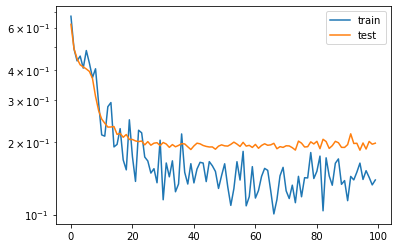

In [84]:
# U-net fast i Fourierdomänen 
# Gör en sammanfattning av allt hittills
# Vad betyder egentligen det vi gör statistikt?
# Skicka runt

save_state = torch.load("/home/emastr/phd/data/unet_state_dict_2022_08_22.Torch")#2022_04_28_3.Torch")
net = Unet(**save_state["settings"])
net.eval()

net.load_state_dict(save_state["state dict"])

plt.semilogy(save_state["train loss"], label='train')
plt.semilogy(save_state["test loss"], label='test')
plt.legend()

#torch.save(unet.state_dict(), "data/unet_state_dict_2022_04_01.Torch") # Kernel size 3
#torch.save(loss_data, "data/unet_loss_2022_04_01.Torch") 

(array([178.,  53.,  17.,   7.,   8.,   5.,   5.,   2.,   2.,   3.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([0.00834158, 0.14021523, 0.27208887, 0.40396251, 0.53583615,
        0.66770979, 0.79958343, 0.93145708, 1.06333072, 1.19520436,
        1.327078  , 1.45895164, 1.59082528, 1.72269893, 1.85457257,
        1.98644621, 2.11831985, 2.25019349, 2.38206713, 2.51394077,
        2.64581442]),
 <BarContainer object of 20 artists>)

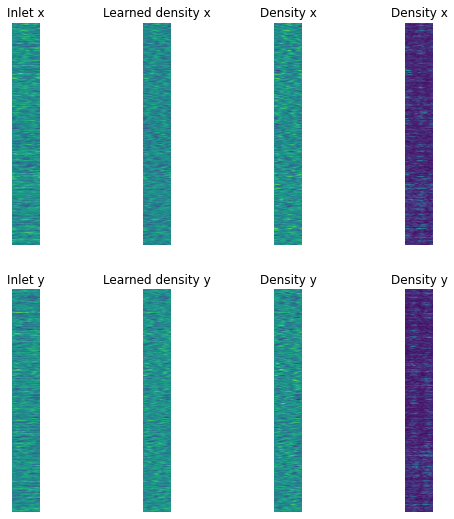

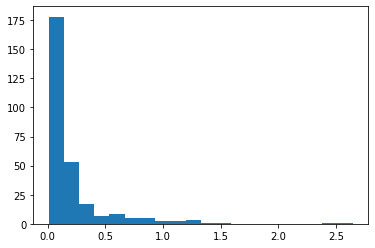

In [87]:
axis=["x","y"]
y = net(X)
plt.figure(figsize=(9,9))
for i in range(2):
    plt.subplot(2,4,4*i+1)
    plt.imshow(X[:,i+2,:].squeeze().detach().numpy(), vmin=-2, vmax=2)
    plt.title(f"Inlet {axis[i]}")
    remove_axes(plt.gca())
    
    plt.subplot(2,4,4*i+2)
    plt.imshow(y[:,i,:].squeeze().detach().numpy(), vmin=-2, vmax=2)
    plt.title(f"Learned density {axis[i]}")
    remove_axes(plt.gca())
    
    plt.subplot(2,4,4*i+3)
    plt.imshow(Y[:,i,:].squeeze().detach().numpy(), vmin=-2, vmax=2)
    plt.title(f"Density {axis[i]}")
    remove_axes(plt.gca())

    plt.subplot(2,4,4*i+4)
    plt.imshow((Y[:,i,:]-y[:,i,:]).abs().squeeze().detach().numpy(), vmin=0, vmax=2)
    plt.title(f"Density {axis[i]}")
    remove_axes(plt.gca())

    
errors = ((Y[740:,:,:]-y[740:,:,:])**2).mean(axis=(1,2))
plt.figure()
errs = [l.item() for l in list(errors.detach().cpu().squeeze())]
plt.hist(errs, bins=20)

0.18248758918790448


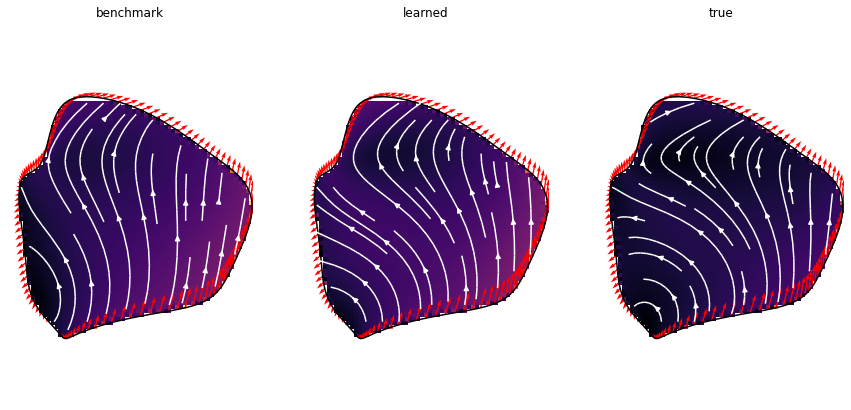

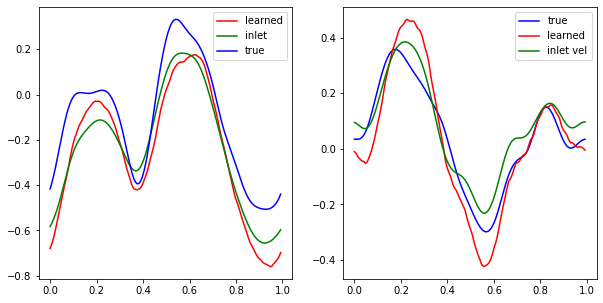

In [112]:
K_in = 20
K_out = 40
M = 128
data = ProblemData.random_problemdata(K=K_in, 
                                      bound_amplitude=0.4,
                                      bound_decay=0.6,#0.5, 
                                      cond_amplitude=0.2,#.5
                                      cond_decay=0.6,#.4
                                      allow_intersections=False, 
                                      allow_net_flow=False,
                                      decay_type="exp",
                                      refine=4,
                                      tol=1e-13)

problem = data.to_problem(n=0)
problem.geometry.grid.ABSCISSA = np.linspace(-1,1,M+1)[:-1]
problem.geometry.grid.WEIGHTS = np.ones((M,)) * 2/M


t = np.linspace(0,2*np.pi,M+1)[:-1]
z = problem.geometry.eval_param(t=t)
w = problem.condition(t)

x = np.zeros((1,4,M))
x[0,0,:],x[0,1,:] = np.real(z), np.imag(z)
x[0,2,:], x[0,3,:] = -np.imag(w), np.real(w)

x = torch.from_numpy(x)
d = net(x)
learned = (d[0,0,:] + 1j*d[0,1,:]).detach().numpy()
benchmark = 1j*w
problem.solve()

u,v = np.real(w), np.imag(w)
x,y = np.real(z), np.imag(z)
# 
densities = [benchmark, learned, problem.density]
titles = ["benchmark", "learned", "true"]

field = lambda z: np.abs(problem.evaluate(z))

plt.figure(figsize=(15,7))
for i in range(3):
    problem.density = densities[i]
    plt.subplot(1,3,i+1)
    plt.title(titles[i])
    problem.geometry.plot(ax = plt.gca(), color="black")
    problem.geometry.plot_field(ax=plt.gca(), func=field, npts=60, apply_mask=True, cmap="inferno", vmin=0, vmax=3)
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=60, apply_mask=True, color="white", density=0.5)
    plt.quiver(x,y,u,v, color="red")
    plt.axis("equal")
    remove_axes(plt.gca())

plt.figure(figsize=(10,5))

angle = t/2/np.pi
plt.subplot(121)
plt.plot(angle, np.real(learned),'r-', label="learned")
plt.plot(angle, np.real(1j*w), 'g-', label="inlet")
plt.plot(angle, np.real(problem.density), 'b-', label="true")
plt.legend()

plt.subplot(122)
plt.plot(angle, np.imag(problem.density), 'b-', label="true")
plt.plot(angle, np.imag(learned), 'r-', label="learned")
plt.plot(angle, np.imag(1j*w), 'g-', label="inlet vel")
plt.legend()


print(np.mean(np.abs(learned - problem.density)**2)**0.5)

In [99]:
print(settings)

{'in_channels': 4, 'min_out_channels': 2, 'out_channels': 2, 'depth': 5, 'batch_norm': 2, 'width': 2, 'kernel_size': 3, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
0.16070397762500743
